<a href="https://colab.research.google.com/github/GenieYoung/Moving-mesh-based-on-harmonic-maps/blob/main/moving_mesh.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
try:
    import firedrake
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/firedrake-install-release-real.sh" -O "/tmp/firedrake-install.sh" && bash "/tmp/firedrake-install.sh"
    import firedrake

try:
  import matplotlib.pyplot as plt
except:
  warning("Matplotlib not imported")

import numpy as np

# Utility Function

In [ ]:
def copy_mesh(mesh):
  coord_space = mesh.coordinates.function_space()
  new_coords = firedrake.Function(coord_space).assign(mesh.coordinates)
  return firedrake.Mesh(new_coords)

def draw_mesh(mesh, label=""):
  fig,ax = plt.subplots()
  firedrake.pyplot.triplot(mesh, axes=ax)
  ax.set_title(label)
  plt.show()

def draw_function(F, label=""):
  fig, ax = plt.subplots()
  colors = firedrake.pyplot.tripcolor(F, axes=ax)
  fig.colorbar(colors)
  ax.set_title(label)
  plt.show()

# Build initial physical and logical mesh

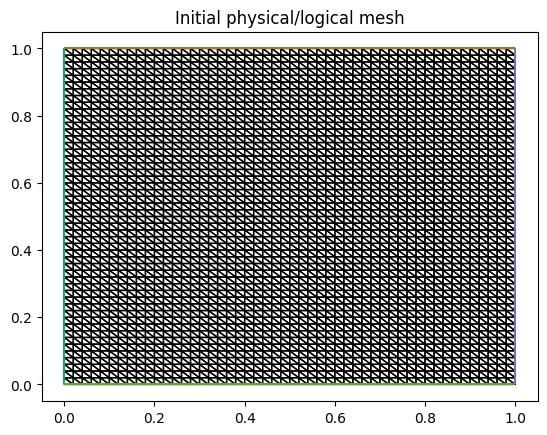

In [ ]:
n = 50
initial_mesh = firedrake.utility_meshes.RectangleMesh(n,n,1,1)

x_mesh = copy_mesh(initial_mesh)
xi_mesh = copy_mesh(initial_mesh)

draw_mesh(initial_mesh, "Initial physical/logical mesh")

# Define benchmark function and metrics

$$
u(x,y)=\tanh(-30[y-0.5-0.25\sin(2\pi x)])
$$

$$
M(x) = \sqrt{1+0.1||\nabla u||_2^2}
$$

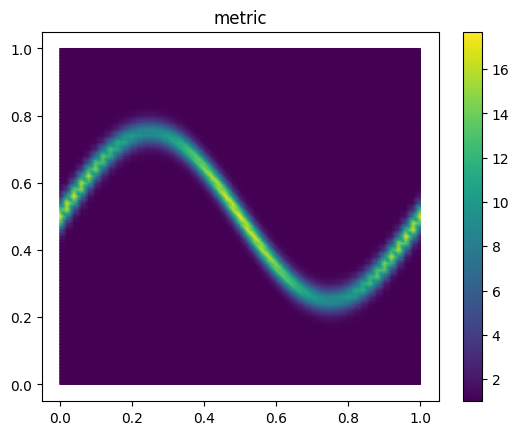

In [ ]:
def U_real(mesh):
  x,y = firedrake.ufl.SpatialCoordinate(mesh)
  return firedrake.ufl.tanh(-30*(y-0.5-0.25*firedrake.ufl.sin(2*firedrake.ufl.pi*x)))

# def U_real(mesh):
#   x,y = firedrake.ufl.SpatialCoordinate(mesh)
#   return firedrake.ufl.tanh(20*(y-0.5))

# def U_real(mesh):
#   x,y = firedrake.ufl.SpatialCoordinate(mesh)
#   #p = 50*((x-0.5)**2+(y-0.5)**2-0.09)
#   p = 50*(x+y-1)**2
#   return 1+20/(firedrake.ufl.exp(p)+firedrake.ufl.exp(-p))

# def U_x(mesh):
#   x,y = firedrake.ufl.SpatialCoordinate(mesh)
#   return (15*firedrake.ufl.pi*firedrake.ufl.cos(2*firedrake.ufl.pi*x))*(1-U_real(mesh)**2)

# def U_y(mesh):
#   return -30*(1-U_real(mesh)**2)

def Metric(mesh):
  return firedrake.ufl.sqrt(1+0.1*(firedrake.ufl.Dx(U_real(mesh),0)**2+firedrake.ufl.Dx(U_real(mesh),1)**2))
  #return firedrake.ufl.sqrt(1+0.1*(U_x()**2+U_y()**2))

def MF(mesh):
  M = firedrake.function.Function(firedrake.functionspace.FunctionSpace(mesh,'Lagrange',1))
  M.interpolate(Metric(mesh))
  return M

draw_function(MF(initial_mesh), "metric")

# Solve the following Possion equation

$$
\begin{cases}
-\nabla \cdot (\frac{1}{M(x)}\nabla \xi) = 0, \\
\xi|_{\partial \Omega} = \xi_b,
\end{cases}\\
$$

# The weak form equation is
$$
\int_\Omega \frac{1}{M(x)}\nabla\xi:\nabla\phi dx=0 \quad \forall \phi\in H_0^1(\Omega)^2
$$

In [ ]:
def solve_possion_equation(mesh):
  VFS = firedrake.VectorFunctionSpace(mesh, "Lagrange", 1)
  xi = firedrake.TrialFunction(VFS)
  vt = firedrake.TestFunction(VFS)

  x,y = firedrake.ufl.SpatialCoordinate(mesh)
  a = (1/MF(mesh))*firedrake.ufl.inner(firedrake.ufl.grad(xi), firedrake.ufl.grad(vt))*firedrake.ufl.dx

  #bcs = firedrake.DirichletBC(VFS,firedrake.ufl.as_vector([x,y]),"on_boundary")
  bc_left = firedrake.DirichletBC(VFS.sub(0), 0, 1)
  bc_right = firedrake.DirichletBC(VFS.sub(0), 1, 2)
  bc_bottom = firedrake.DirichletBC(VFS.sub(1), 0, 3)
  bc_top = firedrake.DirichletBC(VFS.sub(1), 1, 4)
  bcs = [bc_left,bc_right,bc_bottom,bc_top]

  xi_solution = firedrake.Function(VFS)
  problem = firedrake.LinearVariationalProblem(a, 0, xi_solution, bcs=bcs)
  solver = firedrake.LinearVariationalSolver(problem)
  solver.solve()

  return xi_solution

xi_solution = solve_possion_equation(x_mesh)

# draw_function(xi_solution.sub(0), "xi_solution[0]")
# draw_function(xi_solution.sub(1), "xi_solution[1]")

# Generate new logical mesh

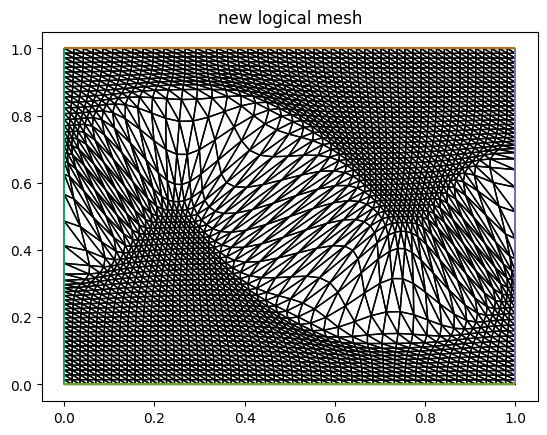

In [ ]:
xi_mesh = firedrake.Mesh(xi_solution)

draw_mesh(xi_mesh, "new logical mesh")

In [ ]:
A = np.array([[[1,2],[3,4]]])
B = np.array([2])
print(A.shape,B.shape)
print(A/B[:,np.newaxis,np.newaxis])

(1, 2, 2) (1,)
[[[0.5 1. ]
  [1.5 2. ]]]


# Generate new physical mesh

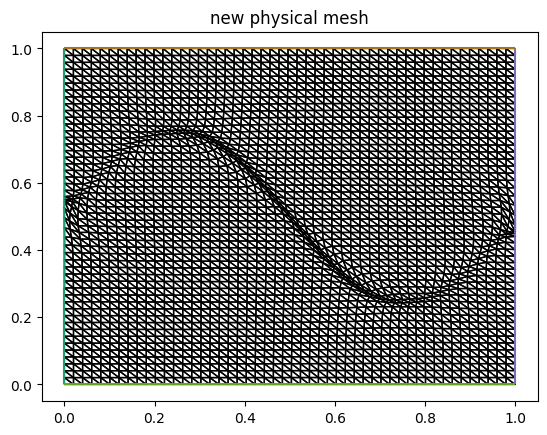

In [ ]:
def generate_new_physical_mesh(x_mesh, xi_mesh, xi_solution):
  grad_space = firedrake.TensorFunctionSpace(x_mesh,"Lagrange",1)
  grad_xi = (firedrake.project(firedrake.ufl.grad(xi_solution),grad_space)).dat.data_ro
  grad_x = np.linalg.inv(grad_xi)
  grad_x = grad_x / (np.abs(np.linalg.det(grad_x)))[:,np.newaxis,np.newaxis]    # why?

  delta_xi = initial_mesh.coordinates.dat.data_ro-xi_mesh.coordinates.dat.data_ro
  delta_xi_L2 = np.linalg.norm(delta_xi,axis=1).reshape(-1,1)
  delta_xi_L2[delta_xi_L2<1e-5] = 0.0
  tau = np.zeros_like(delta_xi_L2, dtype=float)
  tau[delta_xi_L2!=0] = 0.5/delta_xi_L2[delta_xi_L2!=0]
  tau = np.minimum(tau, 0.1)

  delta_x = np.einsum('ijk,ik->ij', grad_x, delta_xi)
  delta_x = delta_x*tau

  x_mesh.coordinates.dat.data[:] = x_mesh.coordinates.dat.data + delta_x

generate_new_physical_mesh(x_mesh, xi_mesh, xi_solution)

draw_mesh(x_mesh, "new physical mesh")

# Repeat above process

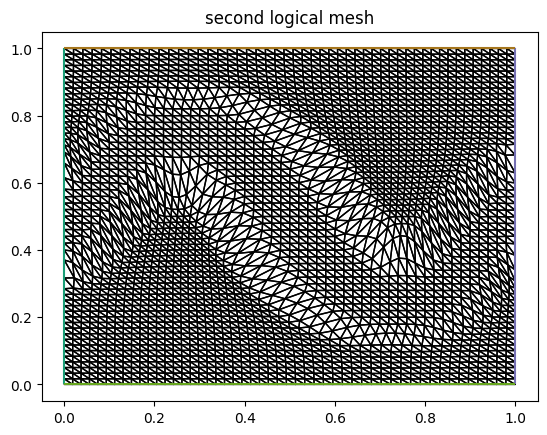

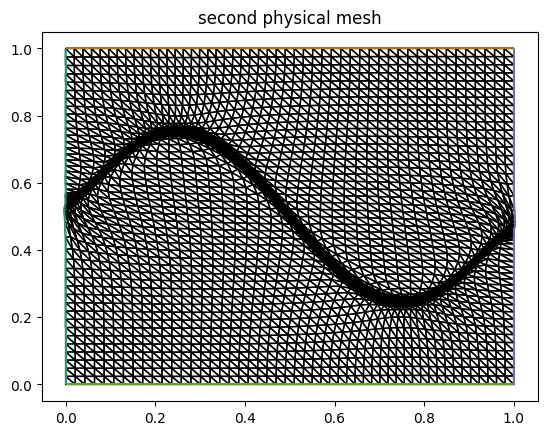

In [ ]:
for i in range(10):
  xi_solution = solve_possion_equation(x_mesh)
  xi_mesh = firedrake.Mesh(xi_solution)
  generate_new_physical_mesh(x_mesh, xi_mesh, xi_solution)

draw_mesh(xi_mesh, "second logical mesh")
draw_mesh(x_mesh, "second physical mesh")

In [ ]:
# grad_space = firedrake.TensorFunctionSpace(x_mesh,"Lagrange",1)
# grad_xi = (firedrake.project(firedrake.ufl.grad(xi_solution),grad_space)).dat.data_ro
# grad_x = np.linalg.inv(grad_xi)

# coords = x_mesh.coordinates.dat.data
# xi_coords = xi_mesh.coordinates.dat.data

# dx = xi_mesh.coordinates.dat.data_ro - initial_mesh.coordinates.dat.data_ro
# tt = np.einsum('ijk,ik->ij', grad_xi, dx)
# plt.figure()
# plt.quiver(coords[:,0], coords[:,1], tt[:,0], tt[:,1],scale=1)

# plt.figure()
# plt.quiver(coords[:,0], coords[:,1], grad_x[:,0,0], grad_x[:,0,1],scale=20)
# plt.quiver(coords[:,0], coords[:,1], grad_x[:,1,0], grad_x[:,1,1],scale=20)
# plt.title("grad_x")
# plt.figure()
# plt.quiver(coords[:,0], coords[:,1], grad_xi[:,0,0], grad_xi[:,0,1])
# plt.quiver(coords[:,0], coords[:,1], grad_xi[:,1,0], grad_xi[:,1,1])
# plt.title("grad_xi")

# delta_xi = initial_mesh.coordinates.dat.data_ro-xi_mesh.coordinates.dat.data_ro
# delta_xi_L2 = np.linalg.norm(delta_xi,axis=1).reshape(-1,1)
# delta_xi_L2[delta_xi_L2<1e-5] = 0.0
# tau = np.zeros_like(delta_xi_L2, dtype=float)
# tau[delta_xi_L2!=0] = 0.5/delta_xi_L2[delta_xi_L2!=0]
# tau = np.minimum(tau, 0.618)

# delta_x = np.einsum('ijk,ik->ij', grad_x, delta_xi)
# plt.figure()
# plt.quiver(coords[:,0], coords[:,1], delta_x[:,0], delta_x[:,1],scale=1)
# delta_x = delta_x*tau
# plt.figure()
# plt.quiver(coords[:,0], coords[:,1], delta_x[:,0], delta_x[:,1],scale=1)

# tmp = copy_mesh(x_mesh)
# tmp.coordinates.dat.data[:] = tmp.coordinates.dat.data + delta_x
# draw_mesh(tmp)

In [ ]:
# xi_coords = xi_mesh.coordinates.dat.data
# x_coords = x_mesh.coordinates.dat.data
# xi_delta = initial_mesh.coordinates.dat.data - xi_coords
# triangles = initial_mesh.coordinates.cell_node_map().values_with_halo

# xi_E = np.ones([len(triangles), 2, 2])
# xi_E[:,:,0] = xi_coords[triangles[:,1]] - xi_coords[triangles[:,0]]
# xi_E[:,:,1] = xi_coords[triangles[:,2]] - xi_coords[triangles[:,0]]

# x_E = np.ones([len(triangles), 2, 2])
# x_E[:,:,0] = x_coords[triangles[:,1]] - x_coords[triangles[:,0]]
# x_E[:,:,1] = x_coords[triangles[:,2]] - x_coords[triangles[:,0]]
# x_E_area = np.abs(np.linalg.det(x_E))

# grad_x = x_E @ (np.linalg.inv(xi_E))

# x_delta = np.zeros([len(x_coords),2])
# x_area = np.zeros([len(x_coords),1])

# for i in range(len(triangles)):
#   x_area[triangles[i,0]] += x_E_area[i]
#   x_area[triangles[i,1]] += x_E_area[i]
#   x_area[triangles[i,2]] += x_E_area[i]
#   x_delta[triangles[i,0]] += ((x_E_area[i]*grad_x[i])@xi_delta[triangles[i,0]])
#   x_delta[triangles[i,1]] += ((x_E_area[i]*grad_x[i])@xi_delta[triangles[i,1]])
#   x_delta[triangles[i,2]] += ((x_E_area[i]*grad_x[i])@xi_delta[triangles[i,2]])

# xi_delta_L2 = np.linalg.norm(xi_delta,axis=1).reshape(-1,1)
# xi_delta_L2[xi_delta_L2<1e-3] = 0.0
# tau = np.ones_like(xi_delta_L2, dtype=float)
# tau[xi_delta_L2!=0] = 0.5/xi_delta_L2[xi_delta_L2!=0]
# tau = np.minimum(tau, 0.618)

# x_delta = x_delta / x_area
# x_delta = x_delta*tau

# new_mesh = copy_mesh(x_mesh)
# new_mesh.coordinates.dat.data[:] = new_mesh.coordinates.dat.data + x_delta

# draw_mesh(new_mesh, "new physical mesh")